In [1]:
import numpy as np
import random
import os
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal

from utils.augment import augment
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from utils.deep import preProcess, smoothLabels, oneHot, applyOneHot, evaluate_set
from utils.visualize import showMe, showHistory


%load_ext autoreload
%autoreload 2


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [15]:

root_path = 'C:/resources/EMG/'
batch_size = 20

post_fix = '_1s_new'

include = ['S101']
# use session2 for validation
train_sessions = []
val_sessions = []
for subject in os.listdir(root_path):
    #if subject not in exclude:
    if subject in include:
        for session in os.listdir(os.path.join(root_path,subject)):
            classes = os.listdir(os.path.join(root_path, subject, session))
            if session == 'session_4':
                val_sessions.append(os.path.join(root_path,subject, session))
            else:
                train_sessions.append(os.path.join(root_path,subject, session))
        #print(f"{len(os.listdir(os.path.join(root_path,subject)))} session loaded from subject: {subject}")
print(f"{len(train_sessions)} sessions loaded for training")
print(f"{len(val_sessions)} sessions loaded for validation")

classes = [i.split('_')[0] for i in classes]
classes = list(dict.fromkeys(classes)).sort()          # Remove duplicates
print(classes)

records = {}
for c in classes:
    class_data = []
    for session in train_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    records[c] = np.concatenate(class_data)

val_records = {}
for c in classes:
    class_data = []
    for session in val_sessions:
        class_data.append(np.load(os.path.join(session,c+post_fix+'.npy'),allow_pickle=True))
    val_records[c] = np.concatenate(class_data)


3 sessions loaded for training
1 sessions loaded for validation
['Chew', 'Eyebrow', 'Rest', 'Smile']


In [24]:
n_channels = records['Rest'].shape[1]
input_length = records['Rest'].shape[2]


X = np.concatenate((list(records.values())),axis = 0)
val_X= np.concatenate((list(val_records.values())),axis = 0)

s = records['Rest'].shape[0]
y = np.arange(len(classes)).repeat(X.shape[0] / len(classes))



val_s = val_records['Rest'].shape[0]
val_y = np.arange(len(classes)).repeat(val_X.shape[0] / len(classes))



c = list(zip(X, y))
random.seed(42)
random.shuffle(c)
X,y = zip(*c)


X = np.array(X).reshape(-1,n_channels,input_length)
y = np.array(y)

val_X = np.array(val_X).reshape(-1,n_channels,input_length)
val_y = np.array(val_y)


y = applyOneHot(y,len(classes))
val_y = applyOneHot(val_y,len(classes))


print(X.shape)
print(y.shape)

print(val_X.shape)
print(val_y.shape)


(900, 4, 500)
(900, 4)
(300, 4, 500)
(300, 4)


In [49]:
X, y = augment(X, y)
print("After augmentation")
print(X.shape)
print(y.shape)

After augmentation
(1800, 4, 500)
(1800, 4)


In [56]:
def get_dense_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    
    l2 = 0.0001
   

    x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(input_layer)
    x     = layers.BatchNormalization()(x)
    

    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)


    # x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)



    x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.1)(x)


    # x     = layers.Dense(30,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)


   
    
    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)

    x     = layers.Flatten()(x)
    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [51]:
def get_model():
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length,1), name='input')
    #x = layers.Flatten()(input_layer)

    l2 = 0.0001
   
    x     = layers.Conv2D(128, kernel_size=(1,20), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(input_layer)
    #x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,10))(x)


    x     = layers.Dense(1000,kernel_regularizer=regularizers.l2(l2))(x)

    x    = layers.AveragePooling2D(pool_size=(1,100))(x)
    #x     = layers.BatchNormalization()(x)
    #x     = layers.Flatten()(x)

   

    # x     = layers.Dense(500,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)

    # x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)

    

    # x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)
    # x     = layers.Dropout(.2)(x)

    
    
    

    #x     = layers.Flatten()(x)

    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    #x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)

    x     = layers.Flatten()(x)
    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [57]:
model = get_dense_model()
#model = get_model()


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                               patience=3, min_lr=1e-7, min_delta = 0.0001)
                              

# early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.000001)

opt = keras.optimizers.SGD(learning_rate=1e-5) #, momentum=0.9)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['categorical_accuracy']
         )


Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4, 500, 1)]       0         
_________________________________________________________________
dense_36 (Dense)             (None, 4, 500, 1000)      2000      
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 500, 1000)      4000      
_________________________________________________________________
dense_37 (Dense)             (None, 4, 500, 200)       200200    
_________________________________________________________________
batch_normalization_27 (Batc (None, 4, 500, 200)       800       
_________________________________________________________________
dense_38 (Dense)             (None, 4, 500, 500)       100500    
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 500, 500)     

Epoch 1/50
90/90 [==============================] - 8s 94ms/step - loss: 1.3286 - categorical_accuracy: 0.5139 - val_loss: 1.4536 - val_categorical_accuracy: 0.3467
Epoch 2/50
90/90 [==============================] - 8s 92ms/step - loss: 1.1388 - categorical_accuracy: 0.5844 - val_loss: 1.4337 - val_categorical_accuracy: 0.3867
Epoch 3/50
90/90 [==============================] - 8s 91ms/step - loss: 1.1174 - categorical_accuracy: 0.5983 - val_loss: 1.3942 - val_categorical_accuracy: 0.3967
Epoch 4/50
90/90 [==============================] - 8s 91ms/step - loss: 1.1057 - categorical_accuracy: 0.6128 - val_loss: 1.3288 - val_categorical_accuracy: 0.4000
Epoch 5/50
90/90 [==============================] - 8s 91ms/step - loss: 1.0604 - categorical_accuracy: 0.6228 - val_loss: 1.2589 - val_categorical_accuracy: 0.4167
Epoch 6/50
90/90 [==============================] - 8s 91ms/step - loss: 1.0428 - categorical_accuracy: 0.6456 - val_loss: 1.2200 - val_categorical_accuracy: 0.4133
Epoch 7/50

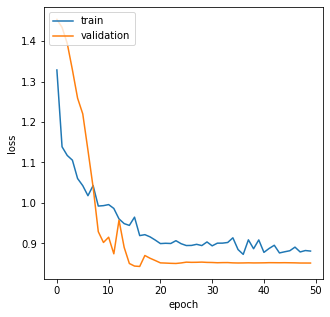

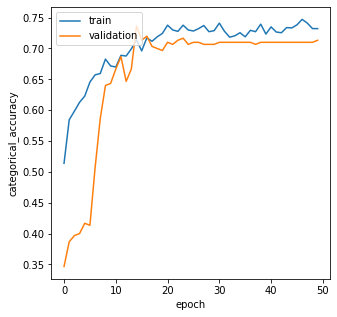

0.7366666793823242


In [58]:
##############################################
############     TRAIN MODEL     #############
##############################################


history = model.fit(X,
                    y,
                    validation_data=(val_X, val_y),
                    batch_size=batch_size,
                    epochs=50,
                    shuffle=True,
                    callbacks = [reduce_lr]
                    )

showHistory(history)      
try:    
    acc = max(history.history['val_accuracy'])
except:
    acc = max(history.history['val_categorical_accuracy'])

print(acc)

In [45]:
skf = StratifiedKFold(n_splits=10)
#tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(1)):
  
    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    #batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))


    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(X_train,
                y_train,
                validation_data=(X_test, y_test),
                batch_size=batch_size,
                epochs=20,
                shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

Batch size: 20


NameError: name 'get_hyper_model' is not defined

In [ ]:
tuner.results_summary()

In [59]:
evaluate_set(model, train_sessions, classes, post_fix, input_length=input_length, log = True)

  0%|          | 0/3 [00:00<?, ?it/s]

####################
Accuracy : 70.0%
[[54  0  1 20]
 [ 0 75  0  0]
 [14 18 25 18]
 [11  5  2 57]]

####################
Accuracy : 77.0%
[[66  3  0  6]
 [ 0 75  0  0]
 [20 31 15  9]
 [ 0  0  0 75]]

####################
Accuracy : 82.0%
[[66  0  2  7]
 [ 0 75  0  0]
 [11 25 32  7]
 [ 1  0  0 74]]

Global accuracy: 76.33%
          Accuracy
Subject           
S101     76.333333


In [60]:
evaluate_set(model, val_sessions, classes,  post_fix, input_length=input_length, log = True)

  0%|          | 0/1 [00:00<?, ?it/s]

####################
Accuracy : 71.0%
[[48  9  1 17]
 [ 0 75  0  0]
 [13 35 18  9]
 [ 2  0  0 73]]

Global accuracy: 71.0%
         Accuracy
Subject          
S101           71
